In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
from PIL import Image

# GIS IMPORTS
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx

# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

In [8]:
input_dir = r"D:\\RECTDNN\\Uncompress\\"
proc_dir  = r"D:\RECTDNN\processing\2024-05-17_13-13-50\Outputs\\"

stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")

init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

In [5]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{input_dir}/*")

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(input_dir + "\\*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

with open(f'{proc_dir}IndexCoords.pkl', 'rb') as handle:
    dict = pickle.load(handle)

In this cell we create the Tile database based on the identified BBOXs...

In [6]:
import re
tile_names = list(dict.keys())

processed_indices = list(dict.keys())

tile_keys = [findIndexKey(a) for a in tile_names]
inde_keys = [findIndexKey(a) for a in processed_indices]

global db
db = {}

# FOR EACH INDEX KEY
for key in np.unique(inde_keys):
    # GET ALL INDICES THAT HAVE THAT KEY
    match_indices = [processed_indices[i] for i, a in enumerate(inde_keys) if a == key]

    # EXTRACT ALL THE TILE INFORMATION FROM THE MATCHING INDICES
    found_tiles   = [getIndivDict(dict, index) for index in match_indices]
    all_tiles = sum(found_tiles, [])

    # PUT IN OUTPUT STRUCTURE
    temp = pd.DataFrame(all_tiles)
    temp = temp.fillna("")
    db[key] = temp

Here we supplement that database with all existing world files...

In [9]:
# READ ALL THE WORLD FILES FROM A DIRECTORY AND CREATE A DATAFRAME
data = read_world_files_from_directory(input_dir)
columns = ['filename', 'line1', 'line2', 'line3', 'line4', 'line5', 'line6']
df = pd.DataFrame(data, columns=columns)

# CONVERT ALL READ PARAMETERS TO NUMERIC
for col in [col for col in df.columns if "line" in col]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# FIND GEOMETRY FOR EACH ROW
df['key']   = df['filename'].apply(findTileKey, db=db)  # FIND THE KEY FOR THE FILENAME
df['key_n'] = pd.to_numeric(df['key'], errors='coerce') # CONVERT IT TO NUMERIC
df['county_polygon'] = df["key_n"].apply(getGeometry)   # USE FIND GEOMETRY FUNCTION

# HEURISTICS - DEFINE WHETHER THE FOUND TRANSFORM IS STATEPLANE 
# BY IT'S SCALE. IF IT'S BIGGER THAN 1, PROBABLY (MOST FILE'S RESOLUTION IS < 0.5 m)
df['STATEPLANE'] = df['line1'] > 1

# INTERSECT DF WITH STATE PLANE SHAPEFILE 
geo_df   = gpd.GeoDataFrame(df, geometry=df['county_polygon']).set_crs("EPSG:3857").to_crs("EPSG:4326")
df_plane = geo_df.overlay(stateplanes, how='intersection')

# CALCULATE EPSG CODE
df['epsg'] = geo_df.apply(getEPSG, df_plane=df_plane, axis=1)
del geo_df, df_plane

df['geotransform'] = df['filename'].apply(getGeotransform, input_dir=input_dir)
df['affine'] = df['geotransform'].apply(getAffine)

In [13]:
db.keys()

dict_keys(['480035', '480036', '480037', '480038', '480039', '480040', '480041', '480042', '480043', '480045', '480046', '480047', '480048', '480049', '480077', '480233', '480267', '480269', '480287', '480289', '48029', '480290', '480291', '480293', '480295', '480296', '480297', '480298', '480299', '480300', '480301', '480304', '480305', '480307', '480308', '480311', '480313', '480315', '480423', '480424', '480641', '480692', '480710', '481094', '481141', '481569', '48201', '485456', '485466', '485468', '485469', '485470', '485486', '485487', '485488', '485491', '485513', '485514', '485516'])

In [11]:
findTileKey("48071C0160E.pgw", db)

'48071'

In [9]:
webmercator = []

RLNN = None
def notify(mess, level=2):
    if level < 4:
        print(mess)

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    fn = row['filename'].split(".")[0]
    image_files = glob.glob(f'{os.path.join(input_dir, fn)}*[!w]')

    if pd.isna(row['epsg']):
        notify(f"NO EPSG {fn}")
        webmercator.append([])
        continue

    if len(image_files) == 0:
        notify(f"NO CORRESPONDING IMAGE {fn}")
        webmercator.append([])
        continue
    bounds, RLNN = findBounds(image_files[0], model=RLNN, verbose=False)

    if len(bounds[0]) == 0:
        notify(f"NO BOUNDS FOUND {image_files[0]}")
        webmercator.append([])
        continue

    bbox = bounds[0].boxes.xyxy.numpy()[0]

    in_crs  = rio.crs.CRS.from_string(f"{row['epsg']}")
    out_crs = rio.crs.CRS.from_epsg(f"3857")

    left, bottom = row['affine'] * (bbox[0], bbox[1])
    right, top   = row['affine'] * (bbox[2], bbox[3])

    new_bbox = rio.warp.transform_bounds(in_crs, out_crs, left, bottom, right, top)
    webmercator.append(new_bbox)
    # print(bbox, [bottom, left, top, right], new_bbox)

df["webmerc"] = webmercator

  0%|          | 0/178 [00:00<?, ?it/s]

NO EPSG 48071C0160E
NO EPSG 48071C0180E
NO EPSG 4812710001D
NO EPSG 4812710002D
NO EPSG 48157C0285L
NO EPSG 48157C0305L
NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C0195M.tif
NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C0415M.tif
NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C0970M.tif
NO BOUNDS FOUND D:\RECTDNN\Uncompress\48201C1030L.tif
NO EPSG 48473C0175E
NO EPSG 4854690002E
NO EPSG 4854690004E
NO EPSG 4854690006E
NO EPSG 4854690008E
NO EPSG 4854690009F
NO EPSG 4854690013E
NO EPSG 4854690017E
NO EPSG 4854690018E
NO EPSG 4854690019E
NO EPSG 4854690021E
NO EPSG 4854690022E
NO EPSG 4854690023E
NO EPSG 4854690024E
NO EPSG 4854690026E
NO EPSG 4854690027E
NO EPSG 4854690028E
NO EPSG 4854690039F
NO EPSG 4854690041F
NO EPSG 4854690042E
NO EPSG 4854690043F
NO EPSG 4854690044E
NO EPSG 4854690046E
NO EPSG 4854690047E
NO EPSG 4854690064E
NO EPSG 4854690066E
NO EPSG 4854690067E
NO EPSG 4854690068E
NO EPSG 4854690069E
NO EPSG 4854690071F
NO EPSG 4854690072F
NO EPSG 4854690081E
NO EPSG 4854690082E
NO E

In [10]:
# Function to convert [left, bottom, right, top] to a shapely Polygon
def bbox_to_polygon(bbox):
    if len(bbox) == 0:
        return None
    left, bottom, right, top = bbox
    return box(left, bottom, right, top)

# Apply the function to the 'bbox' column
df['geometry'] = df['webmerc'].apply(bbox_to_polygon)
gdf = gpd.GeoDataFrame(df)
gdf.dropna(axis=0)

for key in gdf.keys():
    if key == 'geometry':
        continue
    gdf[key] = gdf[key].astype(str)

In [11]:
gdf.to_file(r"D:\RECTDNN\WorldFiles.shp")

In [ ]:
error

In [ ]:
fig, ax = plt.subplots()
gdf.plot(ax=ax, )
ax.set_xlim(-1.07e7, -1.05e7)
ax.set_ylim(3.4e6, 3.6e6)

cx.add_basemap(ax, crs="EPSG:3857")



In [ ]:

def getDimensions(world_file, input_dir):
    # GETS DIMENSIONS OF IMAGE FOR RESPECTIVE WORLD FILE
    image_files = glob.glob(f'{os.path.join(input_dir, world_file.split(".")[0])}*[!w]')
    if len(image_files) == 0:
        return None, None
    
    with Image.open(os.path.join(input_dir, image_files[0])) as img:
        width, height = img.size

        return width, height

test = df['filename'].apply(getDimensions, input_dir=r"D:\RECTDNN\test",)
test = np.array(test)
test['width'] = test[:, 0]
test['height'] = test[:, 1]

ValueError: Columns must be same length as key

In [ ]:
df

,filename,line1,line2,line3,line4,line5,line6,key,key_n,STATEPLANE,county_polygon
0,48029C0265G.tfw,2.500203,0.000147,-0.000087,-2.500144,2.119434e+06,1.375403e+07,48029,48029.0,True,POLYGON ((-10998986.630495073 3442345.14949303...
1,48029C0313F.pgw,0.380997,0.000007,0.000062,-0.380972,5.593432e+05,3.267079e+06,48029,48029.0,False,POLYGON ((-10998986.630495073 3442345.14949303...
2,48029C0385G.tfw,2.499726,-0.000140,-0.000140,-2.499726,2.099650e+06,1.373121e+07,48029,48029.0,True,POLYGON ((-10998986.630495073 3442345.14949303...
3,48029C0405G.tfw,2.500138,0.000098,-0.000225,-2.500125,2.119538e+06,1.373130e+07,48029,48029.0,True,POLYGON ((-10998986.630495073 3442345.14949303...
4,48029C0410G.tfw,2.499803,0.000468,0.000468,-2.499803,2.139485e+06,1.373150e+07,48029,48029.0,True,POLYGON ((-10998986.630495073 3442345.14949303...
...,...,...,...,...,...,...,...,...,...,...,...
173,4854690083E.tfw,0.380923,-0.000046,-0.000043,-0.380890,2.919344e+05,3.220450e+06,485469,485469.0,False,None
174,4854700272D.tfw,0.381176,-0.000013,0.000038,-0.381331,3.074331e+05,3.237506e+06,485470,485470.0,False,POLYGON ((-12708159.932054661 4143532.06560466...
175,4854700274D.tfw,0.381221,0.000006,0.000035,-0.381090,3.073745e+05,3.234041e+06,485470,485470.0,False,POLYGON ((-12708159.932054661 4143532.06560466...
176,4854700274E.tfw,0.381645,-0.000011,-0.000195,-0.381585,3.073728e+05,3.234044e+06,485470,485470.0,False,POLYGON ((-12708159.932054661 4143532.06560466...


In [ ]:
def findTileDatabase(p):
    test = db.get(findIndexKey(p), None)
    if test is None:
        for i in [6, 5]:
            if test is not None:
                continue
            test = db.get(findIndexKey(p)[:i], None)
    return test

bad = 0
tile_coords = []
for i, p in tqdm(enumerate(tiles_bns), total=len(tiles_bns)):
    # FIND TILES 
    curr_db = findTileDatabase(p)
    if curr_db is None or curr_db.empty:
        bad = bad+1
        print("COULD NOT FIND TILE")
        print(p)
        continue

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", p) 

    # GET EQUAL-LENGTH TILENAMES FOR MATCHING
    tns = [a[:len(p)] for a in curr_db['tile'].tolist()]

    # PERFORM MATCHING
    match, score = process.extractOne(p, tns)
    if score > 90:
        tile_coords.append(curr_db[curr_db['tile'] == match]["coords"].tolist())
    else:
        bad = bad+1
        print(f"COULD NOT FIND MATCHES")
        print(p, match, process.extract(p, tns))
        tile_coords.append([])
'''

  0%|          | 0/1406 [00:00<?, ?it/s]

COULD NOT FIND TILE
480243_3
COULD NOT FIND MATCHES
48028710 48028700 [('48028700', 88), ('48028701', 88), ('48028702', 88), ('48028703', 88), ('48028704', 88)]
COULD NOT FIND TILE
480243_4
COULD NOT FIND MATCHES
48003546 48003506 [('48003506', 88), ('48003506', 88), ('48003504', 88), ('48003506', 88), ('48003506', 88)]
COULD NOT FIND MATCHES
4802902  [('', 0)]
COULD NOT FIND MATCHES
480296126 480296016 [('480296016', 89), ('480296012', 89), ('480296012', 89), ('480296016', 89), ('480296016', 89)]
COULD NOT FIND MATCHES
48028777 48028779 [('48028779', 88), ('1480287', 80), ('4802876', 80), ('48028700', 75), ('48028701', 75)]
COULD NOT FIND MATCHES
482010085 482010 [('482010', 90), ('482010028', 89), ('48201C005', 89), ('482010305', 89), ('482010027', 78)]
COULD NOT FIND TILE
48071C0160E
COULD NOT FIND MATCHES
482010290 482010 [('482010', 90), ('482010390', 89), ('482010027', 78), ('482010033', 78), ('482010028', 78)]
COULD NOT FIND MATCHES
4806922  [('', 0)]
COULD NOT FIND MATCHES
4800

'\n# for i, p in tqdm(enumerate(tile_names), total=len(tile_names)):\n    print(i, p, findIndexKey(p))\n    test = db.get(findIndexKey(p), None)\n    if test is None:\n        for i in [5, 6]:\n            if test is not None:\n                continue\n            test = db.get(findIndexKey(p)[:i], None)\n            # test = db[findIndexKey(p)[:i]]\n    error\n\n'

In [ ]:
db.keys()

dict_keys(['480035', '480036', '480037', '480038', '480039', '480040', '480041', '480042', '480043', '480045', '480046', '480047', '480048', '480049', '480077', '480233', '480267', '480269', '480287', '480289', '48029', '480290', '480291', '480293', '480295', '480296', '480297', '480298', '480299', '480300', '480301', '480304', '480305', '480307', '480308', '480311', '480313', '480315', '480423', '480424', '480641', '480692', '480710', '481094', '481141', '481569', '48201', '485456', '485466', '485468', '485469', '485470', '485486', '485487', '485488', '485491', '485513', '485514', '485516'])

In [ ]:
def filterItems(index_list, elements):
    for e in elements:
        if e in index_list:
            index_list.remove(e)
    return index_list

gen_tile_list = []
gen_bbox_list = []

for k, v in dict.items():
    index_list = list(v.keys())
    index_list = filterItems(index_list, [None, 'county', 'transform_info'])

    coord_list = [v[a]['coords'] for a in index_list]

    gen_tile_list.extend(index_list)
    gen_bbox_list.extend(coord_list)

In [ ]:
gen_tile_list = [re.sub("[^0-9]", "", x) for x in gen_tile_list]
tile_names    = [re.sub("[^0-9]", "", x) for x in tile_names]  

In [ ]:
stuff = {}

for i, p in tqdm(enumerate(tile_names), total=len(tile_names)):
    name_list = [a[:len(p)] for a in gen_tile_list]
    matches = process.extract(p, name_list)
    # print(p, matches)
    out = []
    for t in matches:
        bboxes = []
        if t[1] > 90:
            bboxes.extend([gen_bbox_list[i] for i in range(len(name_list)) if name_list[i] == t[0]])
        stuff[p] = bboxes

  0%|          | 0/1406 [00:00<?, ?it/s]

In [ ]:
def findRoads(image, model=None, num_classes=2, num_pyramids=2,
                cnn_run_params=None, cnn_creation_params=None, device="cuda",
                model_checkpoint=f"{data_dir}/FANN/checkpoint_101023.pth"):
    
    if cnn_run_params is None:
        cnn_run_params = {
            "tilesize"   : 2048,
            "edges"      : 0,
            "dims_rep"   : None,
            "n_pyramids" : num_pyramids,
            "num_dim"    : num_classes,
            "device"     : device
        }
    
    if cnn_creation_params is None:
        cnn_creation_params = {
            "num_classes" : num_classes,
            "inputsize"   : num_pyramids,
        }
    
    # Input handling
    if isinstance(image, np.ndarray):
        image = [image] # Make iterable if needed
    
    # Initialize model if needed
    if model is None:
        model = TPNN(**cnn_creation_params)
        model.load_state_dict(torch.load(model_checkpoint)['model_state_dict'])
    model = model.to(device)
    
    # PROCESS IMAGE
    for im in image:
        outputs, _ = split_and_run_cnn(im, model, **cnn_run_params)
    
    # background, grid, roads = outputs[:, :, 0], outputs[:, :, 1], outputs[:, :, 2]
    
    model = model.to("cpu")
    torch.cuda.empty_cache()
    
    outputs = outputs * 255
    outputs = outputs.astype(np.uint8)
    
    # return (background.T, grid.T, roads.T), model
    return outputs, model

def findBounds(image_fn, model=None, 
        model_weights=f"{data_dir}RLNN/weights050124.pt",
        creation_params=None,
        device="cpu",
        ):
    
    if creation_params is None:
        target_size = 512
        original_shapes = []

        # COCO DATASET PARAMS
        category_labels = {
            0 : "County",
            1 : "Tile",
            2 : "Box",
            3 : "Legend"
        }

        categories=[0, 1]

    input_folder = os.path.dirname(os.path.abspath(image_fn))

    # Initialize model
    if model is None:
        model = ultralytics.YOLO(model_weights).to("cpu")

    model = model.to(device)
    
    results = model(image_fn, imgsz=target_size)

    return results, model


def getRoadPoints(fn, model=None):
    # LOAD IMAGE AS NUMPY ARRAY
    image = np.asarray(cv2.imread(fn))

    # RUN CNN
    out, FANN = findRoads(image, model=model)

    # RUN YOLO
    outbbox, RLNN = findBounds(fn)

    # REMOVE ANY CNN OUTSIDE BOUNDS
    bounds = outbbox[0].boxes.xyxy.numpy().astype(np.int32).flatten()
    mask  = np.zeros(out.shape)
    mask[bounds[1]:bounds[3], bounds[0]:bounds[2], :] = 1
    out = out * mask
    out = out.astype(np.uint8)

    # THIN CNN OUTPUTS
    thin = cv2.ximgproc.thinning(out[:, :, 1], thinningType=cv2.ximgproc.THINNING_GUOHALL)

    # OUTPUT X AND Y
    y, x = np.where(np.asarray(thin > 0))

    out_struct = {
        "x" : x,
        "y" : y,
        "FANN" : FANN,
        "RLNN" : RLNN,
        "thin" : thin,
        "raw"  : out,
        "bbox" : outbbox
    }
    
    return out_struct

  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-13_19-10-57\Inputs\4800350495B.jpg: 512x512 1 bounds, 283.4ms
Speed: 0.0ms preprocess, 283.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)


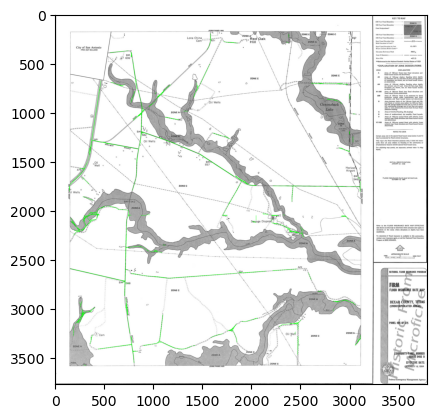

In [ ]:
def findIntersections(lines):
    intersections = []
    for i in tqdm(range(len(lines))):
        for j in range(i+1, len(lines)):
            line1 = lines[i][0]
            line2 = lines[j][0]

            x1, y1, x2, y2 = line1
            x3, y3, x4, y4 = line2

            # Calculate intersection point
            denominator = ((x1 - x2) * (y3 - y4)) - ((y1 - y2) * (x3 - x4))
            if denominator != 0:
                intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
                intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

                # Add intersection point to list
                intersections.append((int(intersect_x), int(intersect_y)))
    return intersections

def findInetersections_vectorized(lines):
    intersections = []

    # Convert lines to numpy array for easier manipulation
    lines = lines[:, 0, :]  # Extracting the lines from the unnecessary dimensions

    # Extracting line coordinates
    x1, y1, x2, y2 = lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3]

    # Reshaping to make calculations easier
    x1, y1, x2, y2 = x1.reshape(-1, 1), y1.reshape(-1, 1), x2.reshape(-1, 1), y2.reshape(-1, 1)

    # Calculate differences and determinants
    dx, dy = x2 - x1, y2 - y1
    det = dx * dy[:, np.newaxis] - dy * dx[:, np.newaxis]

    # Check for non-parallel lines
    non_parallel_mask = det != 0

    # Calculate intersection points
    intersect_x = ((x1 * y2 - y1 * x2) * dx - (x1 - x2) * (x1 * dy - y1 * dx)) / det
    intersect_y = ((x1 * y2 - y1 * x2) * dy - (y1 - y2) * (x1 * dy - y1 * dx)) / det

    # Check for valid intersections
    valid_mask = (intersect_x >= 0) & (intersect_y >= 0) & (intersect_x < image.shape[1]) & (intersect_y < image.shape[0])

    # Filter out invalid intersections and non-parallel lines
    valid_intersections = np.column_stack((intersect_x[valid_mask & non_parallel_mask], intersect_y[valid_mask & non_parallel_mask]))

    # Convert intersection points to integer coordinates
    valid_intersections = valid_intersections.astype(int)

    # Remove duplicate intersections
    valid_intersections = np.unique(valid_intersections, axis=0)

    return valid_intersections

def toTF(a):
    a[a > 0] = 1
    a[a <= 0] = 0
    return a

def filterIntersections(inters, lines, fn):
    # APPROACH WITH IMAGE FILTERING. DOESNT WORK
    image_filter = np.asarray(cv2.imread(fn) * 0)
    inter_filter = np.asarray(cv2.imread(fn) * 0)[:, :, 0]

    # Plot the lines
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_filter, (x1, y1), (x2, y2), (255, 255, 255), 2)

    image_filter = image_filter[:, :, 0]
    # CREATE IMAGE MASK
    # Extract x, y coordinates of intersection points
    x_coords, y_coords = zip(*inters)
    # Set the intersection points to white (255) in the mask
    inter_filter[y_coords, x_coords] = 255
    print(inter_filter.shape)
    print(image_filter.shape)


    return toTF(image_filter) * toTF(inter_filter)

def findInetersections_shapely(lines): 
    line_strings = [LineString([(line[0][0], line[0][1]), (line[0][2], line[0][3])]) for line in lines]

    # Create a GeoDataFrame with LineString objects
    gdf = gpd.GeoDataFrame(geometry=line_strings)

    # Calculate intersections
    temp = gdf.unary_union.intersection(gdf.geometry)
    intersection_points = gpd.GeoSeries([point for point in temp if isinstance(point, MultiPoint) or isinstance(point, Point)])
    intersections = gpd.GeoDataFrame(geometry=intersection_points.explode(index_parts=False)).reset_index(drop=True)
    return intersections

fn = tiles[4]
points = getRoadPoints(fn, )

image = np.asarray(cv2.imread(fn))

# Perform Hough Line Transform
lines  = cv2.HoughLinesP(points['thin'], 1, np.pi/720, threshold=20, minLineLength=20, maxLineGap=50)
inters = findInetersections_shapely(lines)

# Plot the lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert BGR image to RGB for plotting
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

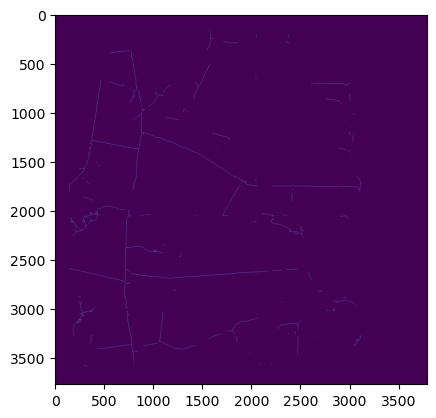

In [ ]:
plt.imshow(points['thin'])

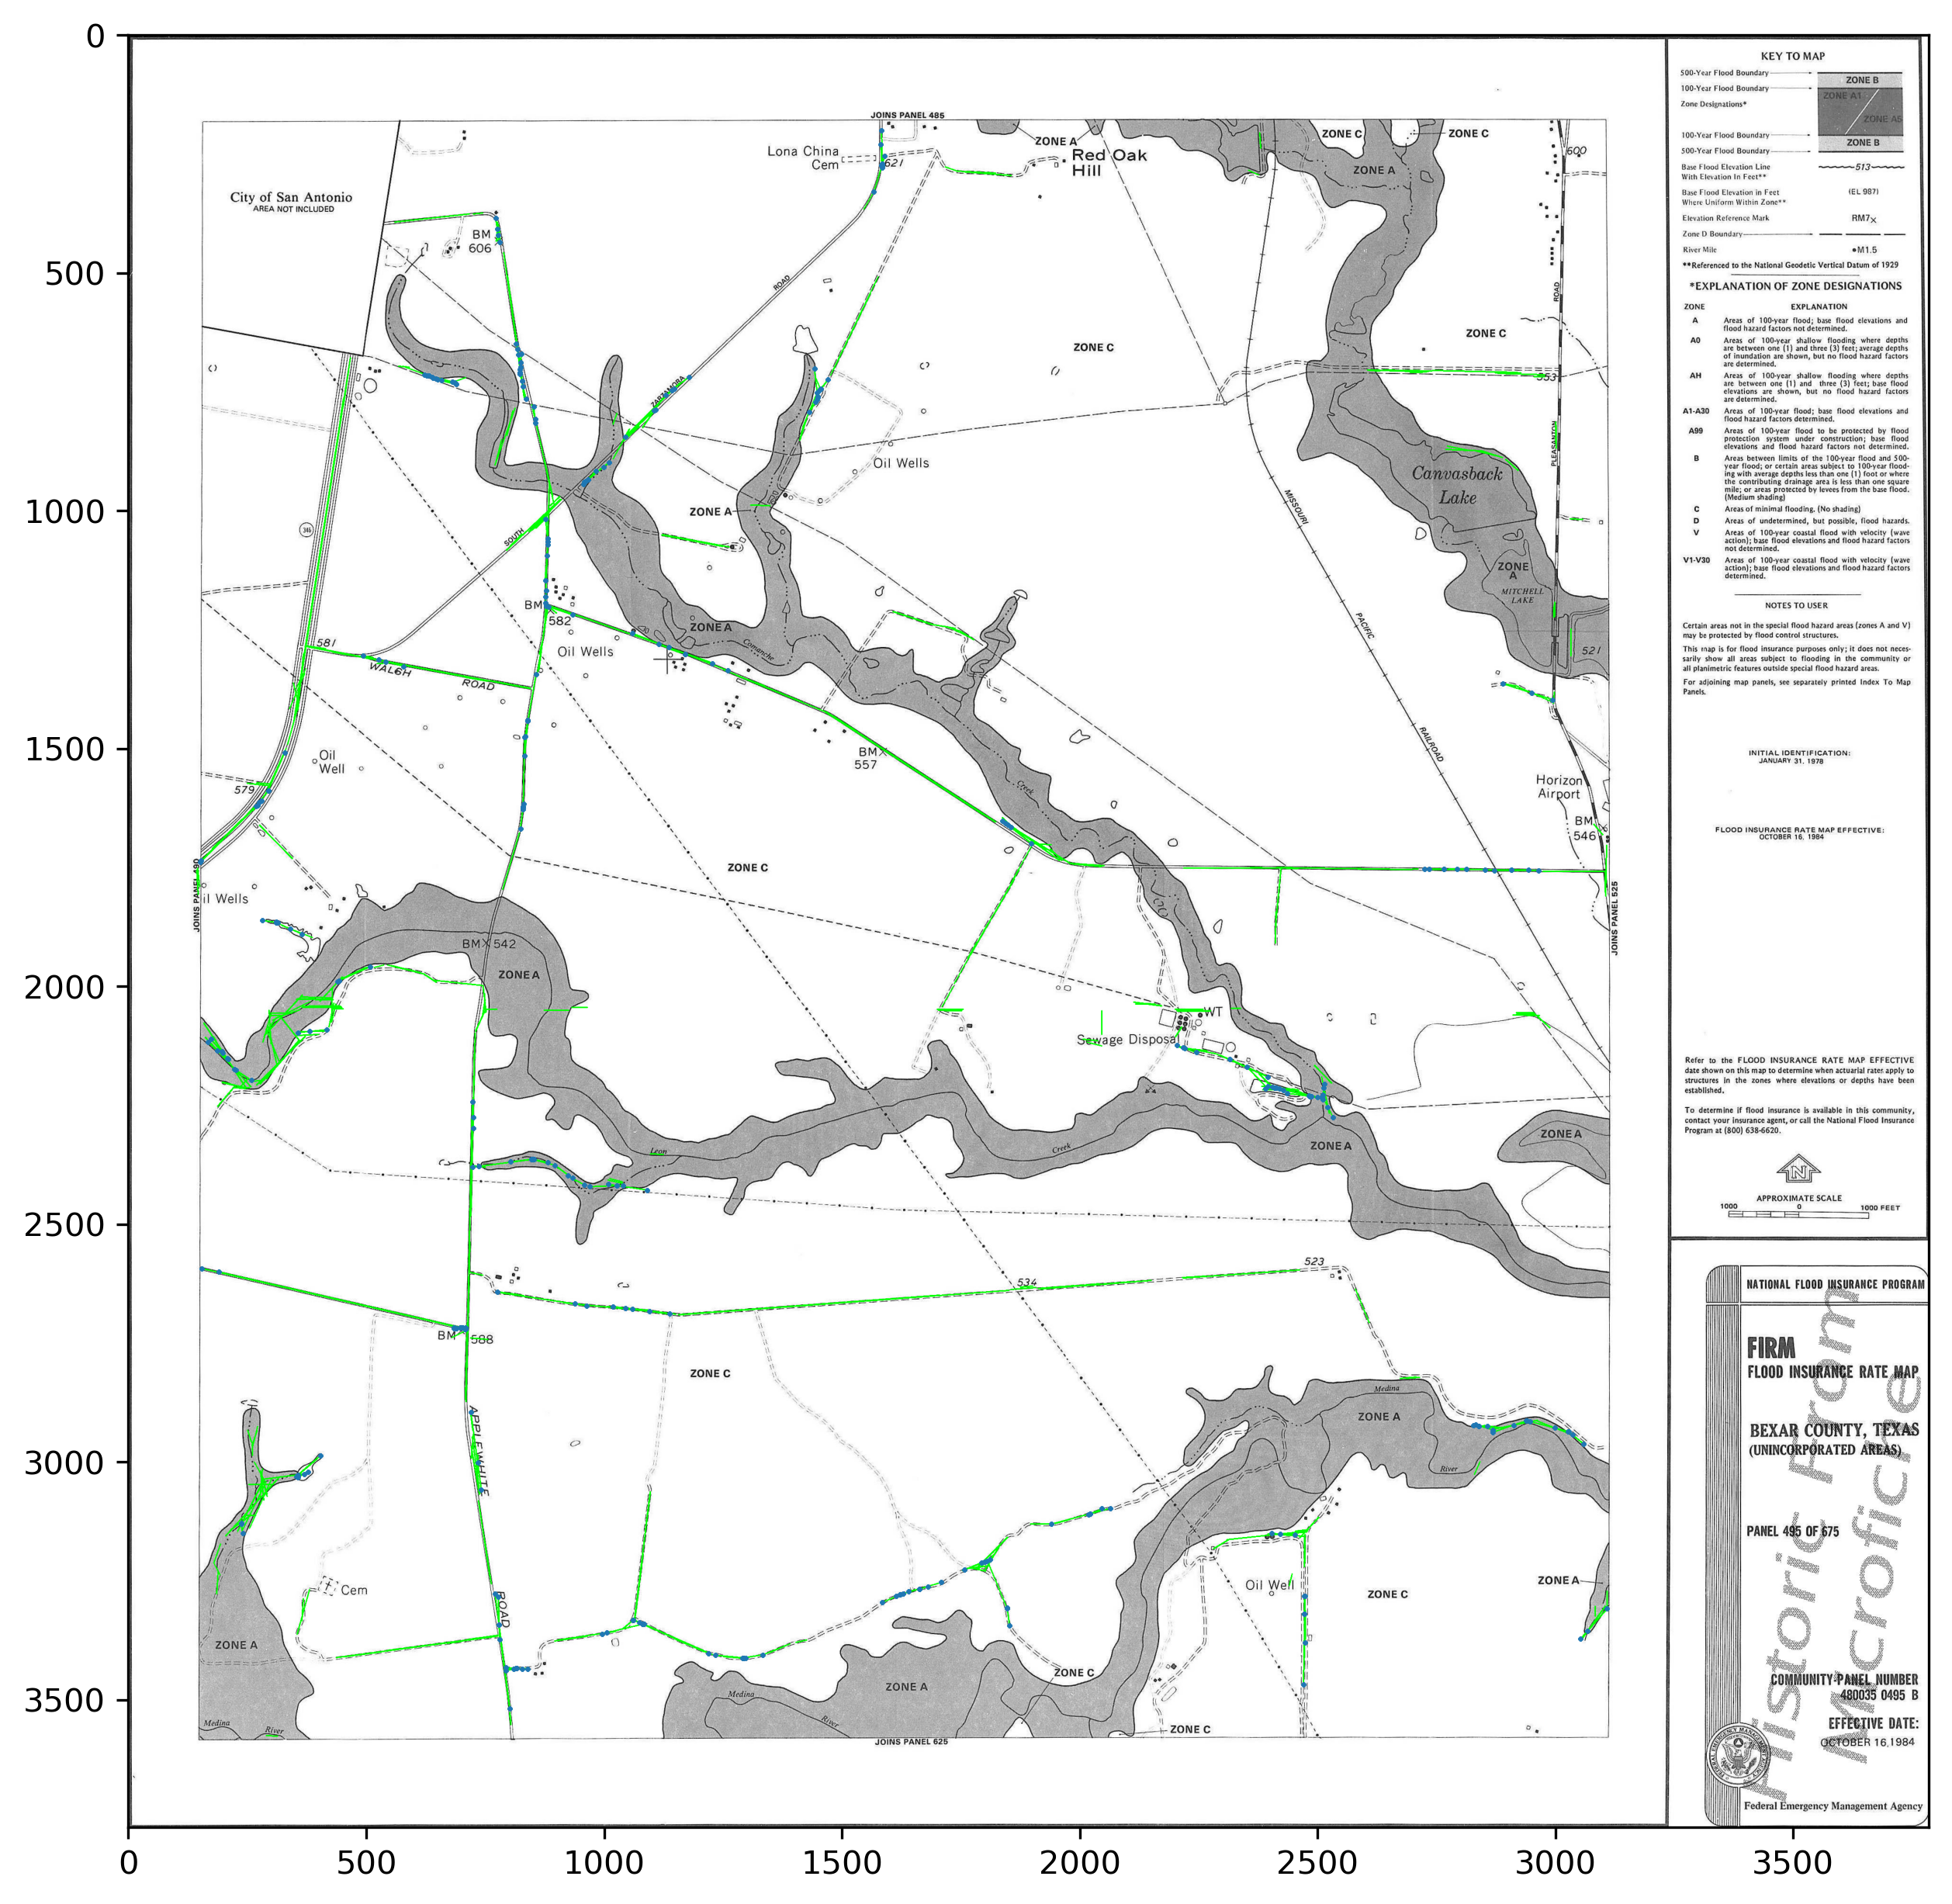

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.imshow(image_rgb)
ax.scatter(inters.geometry.x.tolist(), inters.geometry.y.tolist(), marker='x', s=0.5)
fig.savefig("test.png")

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import pyproj

def longitude_to_utm_zone(lon):
    """Convert longitude to UTM zone number."""
    return int((lon + 180) / 6) + 1

# Example polygon data
polygons = [
    Polygon([(0, 0), (1, 0), (1, 1), (0, 1), (0, 0)]),
    Polygon([(-10, -10), (-9, -10), (-9, -9), (-10, -9), (-10, -10)]),
    # Add more polygons as needed
]

gdf = gpd.GeoDataFrame({'geometry': polygons})

gdf['centroid'] = gdf.geometry.centroid
gdf['longitude'] = gdf.centroid.x
gdf['utm_zone'] = gdf['longitude'].apply(longitude_to_utm_zone)

print(gdf[['geometry', 'centroid', 'longitude', 'utm_zone']])

                                            geometry  \
0  POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....   
1  POLYGON ((-10.00000 -10.00000, -9.00000 -10.00...   

                    centroid  longitude  utm_zone  
0    POINT (0.50000 0.50000)        0.5        31  
1  POINT (-9.50000 -9.50000)       -9.5        29  
